In [43]:
import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import scipy
import os

from utils import plot_histogram
from var import *

In [44]:
#set seed to 0 for reproducibility of results
np.random.seed(0)

In [45]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/guide_assignment/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

<h3> 1. Assessing extent of guide overassignment issue </h3>

In [46]:
#load raw anndata object
adata = sc.read_h5ad('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/20230113_all_cells.h5ad')

In [47]:
#select all guides by selecting the names which do not start with ENSG in var_names
targeted_tf_guides = list(adata.var_names[~adata.var_names.str.startswith('ENSG')])
#use list comprehension to split targeted_tf_guides by '_' and select the first element of the list
targeted_tf = [x.split('_')[0] for x in targeted_tf_guides]

In [48]:
# Create a list of expected guides including the control guides 
expected_guides = [
    'AIRE',
    'ASCL1',
    'DLX1',
    'IRF3',
    'LHX6',
    'MAFB',
    'MYOD1',
    'NEUROG2',
    'OLIG2',
    'PROX1',
    'RORA',
    'RORB',
    'SATB2',
    'sgRNA1_SCP',
    'sgRNA6_SCP',
    'ONE_INTERGENIC_SITE_1194'
]

[i for i in expected_guides if i not in targeted_tf]

['sgRNA1_SCP', 'sgRNA6_SCP', 'ONE_INTERGENIC_SITE_1194']

In [49]:
#save counts in adata counts layer
adata.layers['counts'] = adata.X.copy()
#filter adata for cells with total_counts > 5000
adata_filtered = adata[adata.obs['total_counts'] > 5000].copy()

In [50]:
#filter adata_filtered for expected tf with regex
adata_filtered = adata_filtered[:, adata_filtered.var_names.str.contains('|'.join(expected_guides))].copy()

In [61]:
#normalize adata_filtered with scanpy
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
#create log transformed layer
adata_filtered.layers["log_transformed"] = np.log1p(adata_filtered.X)



In [62]:
#create function to convert adata X (sparse marix) to convert to 2d array
def sparse_to_2d_arr(adata):

    #convert sparse matrix to dense matrix
    dense_count_mtx=adata.X.todense()
    print(dense_count_mtx)
    #convert matrix into 2d array
    dense_count_2d_arr=np.array(dense_count_mtx)
    #convert 2d array to dtype int
    dense_count_2d_arr=dense_count_2d_arr.astype(int)

    return dense_count_2d_arr

In [63]:
#Create a function to count the number of times each value occurs in each row
def count_guide_frequency(dense_count_2d_arr):

        
    m = dense_count_2d_arr.shape[0]    
    n = dense_count_2d_arr.max()+1
    count_frequncy_arr = np.zeros((dense_count_2d_arr.max()+1,dense_count_2d_arr.shape[1]))

    for x in range(dense_count_2d_arr.shape[1]):
        bin_count_arr = np.bincount(dense_count_2d_arr[:,x])
        

        #create zero array to add to bin_count_arr to make the length of the array equal to the max value in dense_count_2d_arr
        n_filler = n-len(bin_count_arr)
        zero_filler = np.zeros(n_filler)
        full_bin_count_arr = np.concatenate((bin_count_arr,zero_filler))
        count_frequncy_arr[:,x] = full_bin_count_arr 
        

    return count_frequncy_arr #exclude first column as it only consists of zeros

In [64]:
dense_count_2d_arr = sparse_to_2d_arr(adata_filtered)
guide_frequency = count_guide_frequency(dense_count_2d_arr)

[[0.00000000e+00 0.00000000e+00 5.42815723e+03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  1.26742706e+01 6.33713531e+00]
 [5.44378662e+02 7.10059128e+01 1.18343191e+01 ... 0.00000000e+00
  0.00000000e+00 1.18343191e+01]
 ...
 [0.00000000e+00 0.00000000e+00 1.54798765e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.68054199e+00 ... 0.00000000e+00
  0.00000000e+00 2.90416260e+01]
 [0.00000000e+00 2.45821047e+00 2.45821047e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


<h3> 1.1. guide UMI count distribution </h3>

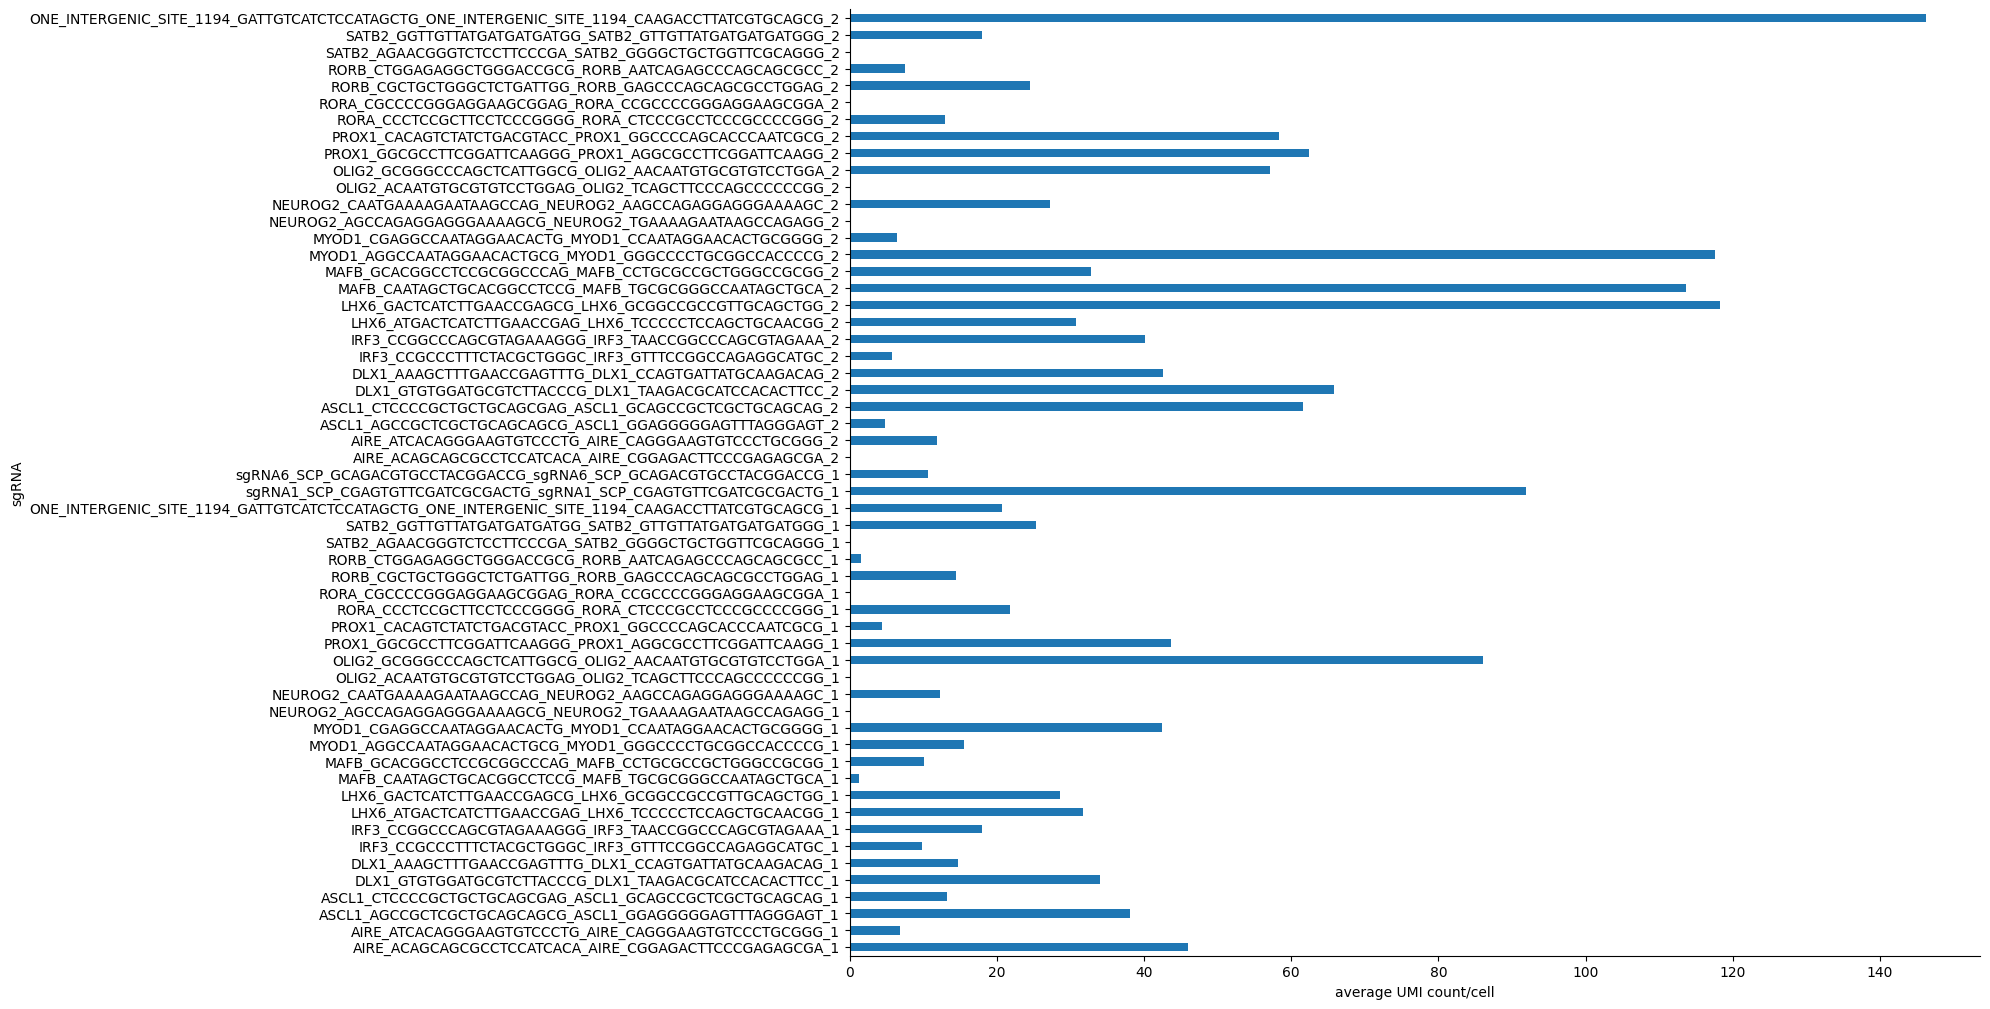

In [65]:
#plot barplot from pandas Series
tf_guides_series = pd.Series(
    np.array(adata_filtered.layers['counts'].mean(0)).flatten(),
    index=adata_filtered.var_names
)
fig, ax = plt.subplots()
tf_guides_series.plot.barh(
    figsize=(20,10)
    )
fig.subplots_adjust(left=0.5)
#adjust y axis to avoid overlap of text
ax.set_yticks(np.arange(len(tf_guides_series)))
fig.tight_layout()
#label x and y axis
plt.xlabel('average UMI count/cell')
plt.ylabel('sgRNA')


plt.savefig(f'{figures_folder}{today}_tf_guides_barplot.pdf',bbox_inches='tight')

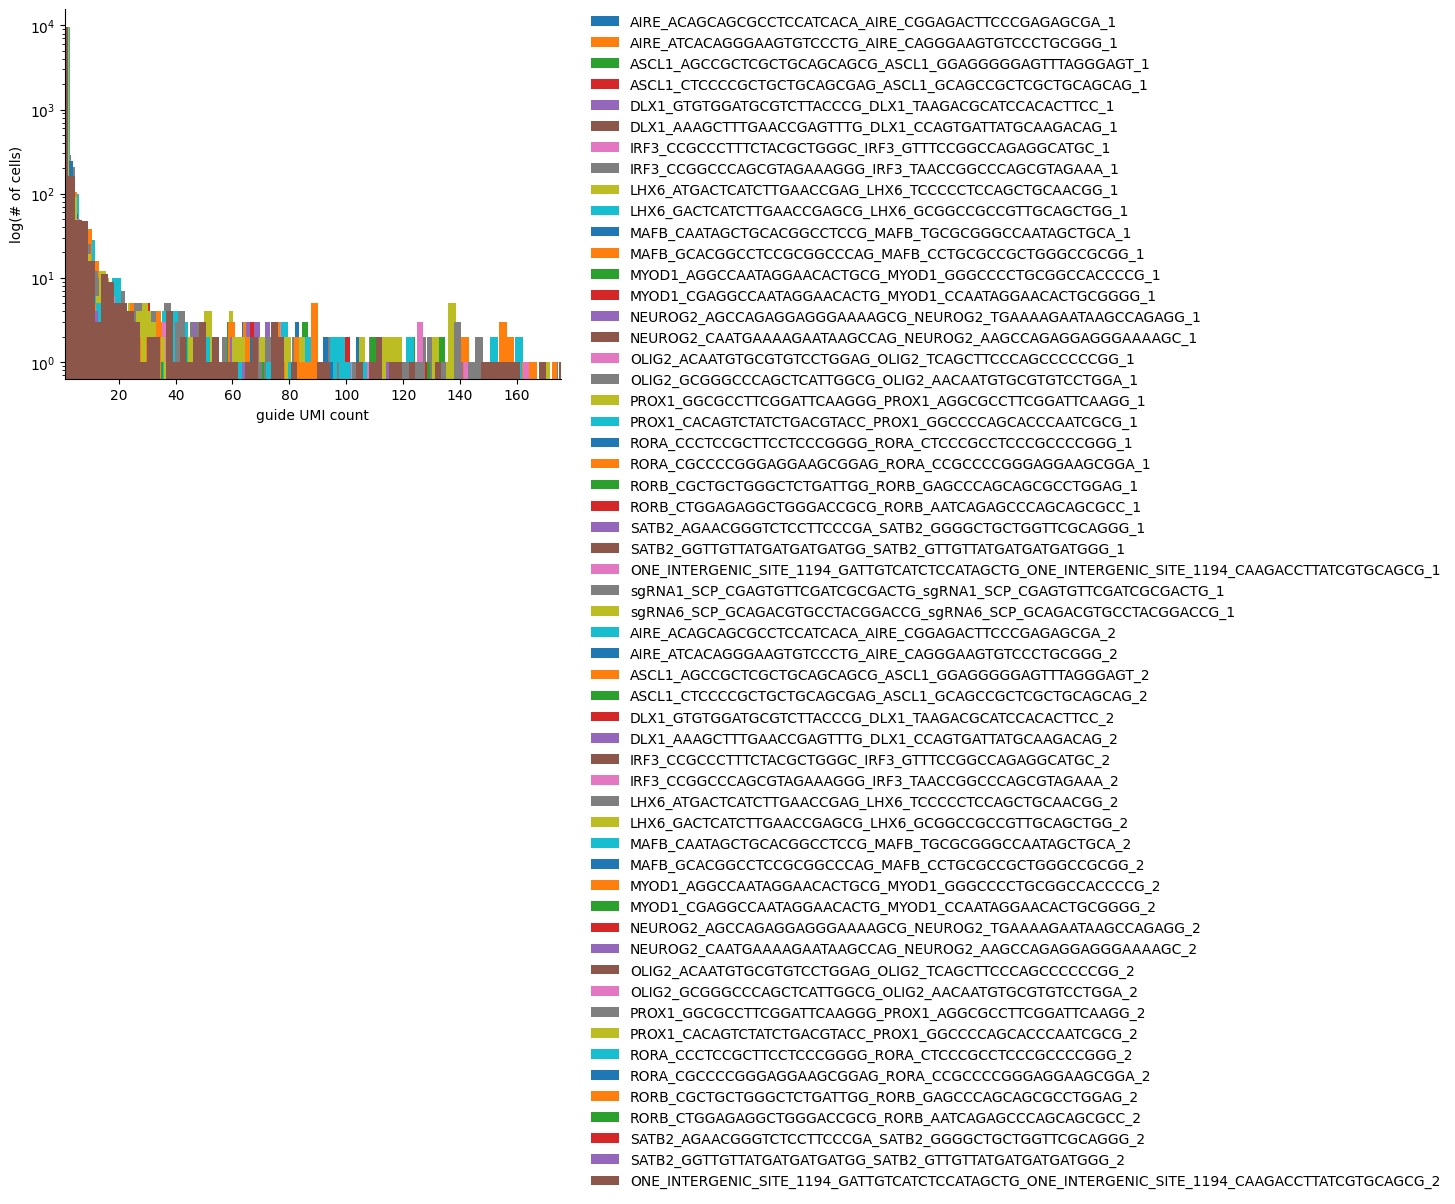

In [66]:
#plot lineplot for each row in count_frequncy_arr
for x in range(0,guide_frequency.shape[1]):
    # plt.plot(np.arange(1,guide_frequency.shape[0]),guide_frequency[1:,x])
    plt.hist(guide_frequency[1:,x], bins=100)
    plt.xlabel('normalised UMI count')
    
    plt.ylabel('log(# of cells)')
    
    #plot adata.var_names for each gene as legend

    plt.legend(adata_filtered.var_names,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    #set lower xlim to 1, to exclude zero values
    plt.gca().set_xlim(left=1)

    #log scale y axis
    plt.gca().set_yscale('log')
#save figure
plt.savefig(f'{figures_folder}{today}_tf_guides_frequency.pdf',bbox_inches='tight')
# plt.close()

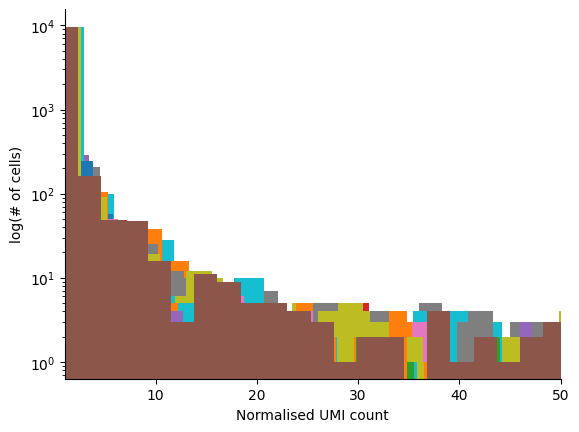

In [67]:
#plot lineplot for each row in count_frequncy_arr
for x in range(0,guide_frequency.shape[1]):
    # plt.plot(np.arange(1,guide_frequency.shape[0]),guide_frequency[1:,x])
    plt.hist(guide_frequency[1:,x], bins=200)
    plt.xlabel('Normalised UMI count')
    
    plt.ylabel('log(# of cells)')
    #limit x axis to interval 1 and 100
    plt.xlim([1,50])

    #log scale y axis
    plt.gca().set_yscale('log')
    
    #set lower xlim to 1, to exclude zero values
    #plt.gca().set_xlim(left=1)
plt.savefig(f'{figures_folder}{today}_tf_guides_gene_frequency_interval_1_50.pdf',bbox_inches='tight')

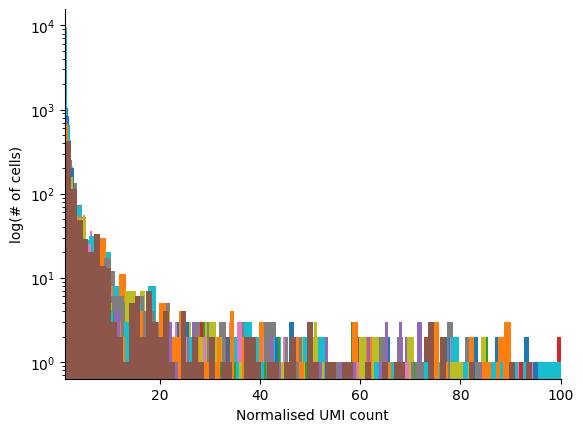

In [68]:
#plot lineplot for each row in count_frequncy_arr
for x in range(0,guide_frequency.shape[1]):
    # plt.plot(np.arange(1,guide_frequency.shape[0]),guide_frequency[1:,x])
    plt.hist(guide_frequency[1:,x], bins=200)
    plt.xlabel('Normalised UMI count')
    
    plt.ylabel('log(# of cells)')
    #limit x axis to interval 1 and 100
    plt.xlim([1,100])

    #log scale y axis
    plt.gca().set_yscale('log')
    
    #set lower xlim to 1, to exclude zero values
    # plt.gca().set_xlim(left=1)
    # plt.savefig(f'{figures_folder}{today}_tf_guides_gene_frequency_interval_10_100.pdf',bbox_inches='tight')

<h3> 1.2.1 Guide fraction for individual guides</h3>

In [32]:
#compute fraction per column to determine guide fraction of each cell 
guide_frac_per_cell=dense_count_2d_arr.T/dense_count_2d_arr.sum(axis=1)
guide_frac_per_cell=guide_frac_per_cell.T
#sort fraction in ascending order for each row
guide_frac_per_cell.sort(axis=0)
#remove all zeros in a column 
guide_frac_per_cell=guide_frac_per_cell[~np.all(guide_frac_per_cell == 0, axis = 1),:]

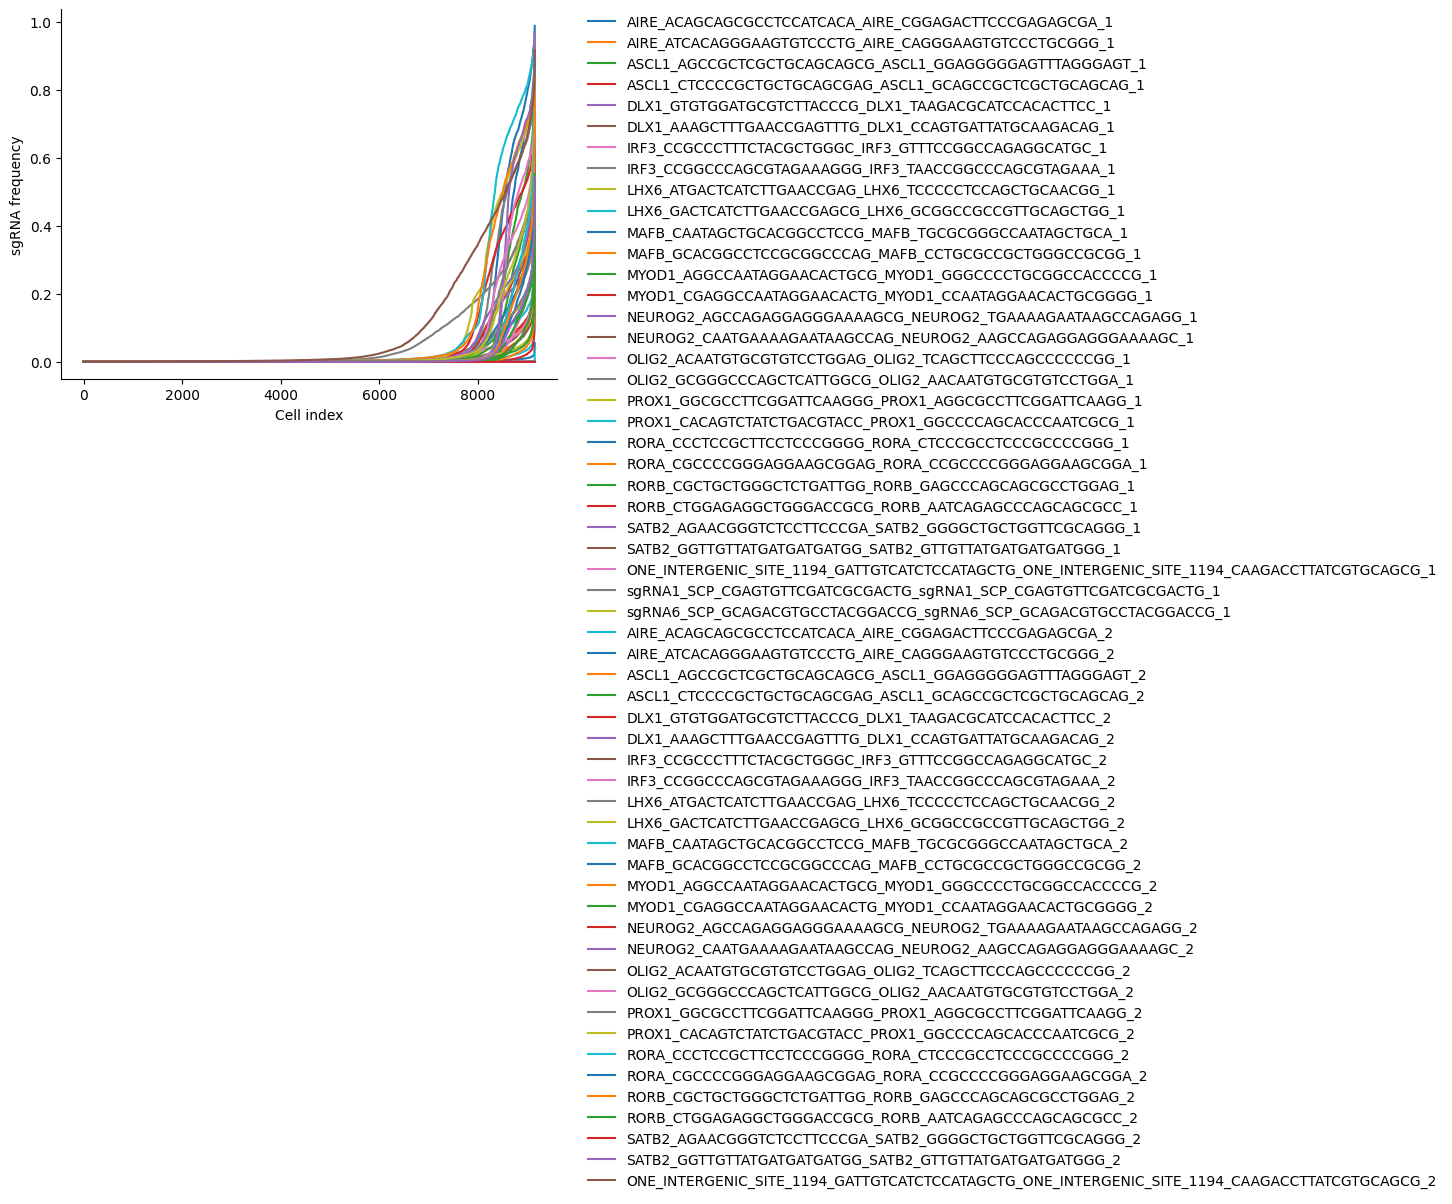

In [78]:
for x in range(0,guide_frequency.shape[1]):
    
    plt.plot(guide_frac_per_cell[:,x])

    plt.xlabel('Cell index')
    
    plt.ylabel('sgRNA frequency')
    
    #plot adata.var_names for each gene as legend
    plt.legend(adata_filtered.var_names,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.savefig(f'{figures_folder}{today}_tf_fraction_per_cell.pdf',bbox_inches='tight')
    

In [37]:
guides

Index(['AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAGAGCGA',
       'AIRE_ATCACAGGGAAGTGTCCCTG_AIRE_CAGGGAAGTGTCCCTGCGGG',
       'ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTTAGGGAGT',
       'ASCL1_CTCCCCGCTGCTGCAGCGAG_ASCL1_GCAGCCGCTCGCTGCAGCAG',
       'DLX1_GTGTGGATGCGTCTTACCCG_DLX1_TAAGACGCATCCACACTTCC',
       'DLX1_AAAGCTTTGAACCGAGTTTG_DLX1_CCAGTGATTATGCAAGACAG',
       'IRF3_CCGCCCTTTCTACGCTGGGC_IRF3_GTTTCCGGCCAGAGGCATGC',
       'IRF3_CCGGCCCAGCGTAGAAAGGG_IRF3_TAACCGGCCCAGCGTAGAAA',
       'LHX6_ATGACTCATCTTGAACCGAG_LHX6_TCCCCCTCCAGCTGCAACGG',
       'LHX6_GACTCATCTTGAACCGAGCG_LHX6_GCGGCCGCCGTTGCAGCTGG',
       'MAFB_CAATAGCTGCACGGCCTCCG_MAFB_TGCGCGGGCCAATAGCTGCA',
       'MAFB_GCACGGCCTCCGCGGCCCAG_MAFB_CCTGCGCCGCTGGGCCGCGG',
       'MYOD1_AGGCCAATAGGAACACTGCG_MYOD1_GGGCCCCTGCGGCCACCCCG',
       'MYOD1_CGAGGCCAATAGGAACACTG_MYOD1_CCAATAGGAACACTGCGGGG',
       'NEUROG2_AGCCAGAGGAGGGAAAAGCG_NEUROG2_TGAAAAGAATAAGCCAGAGG',
       'NEUROG2_CAATGAAAAGAATAAGCCAG_NEUROG2_AAGCCAGAGGA

In [41]:
adata_filtered

AnnData object with n_obs × n_vars = 11814 × 56
    obs: 'barcodes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'sample', 'barcode'
    var: 'feature_types', 'genome', 'SYMBOL', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mt'
    layers: 'counts', 'log_transformed'

AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAGAGCGA
[[  0.        0.     ]
 [  0.        0.     ]
 [544.37866   0.     ]
 ...
 [  0.        0.     ]
 [  0.        0.     ]
 [  0.        0.     ]]
AIRE_ATCACAGGGAAGTGTCCCTG_AIRE_CAGGGAAGTGTCCCTGCGGG
[[  0.         14.513789 ]
 [  0.          0.       ]
 [ 71.00591   153.84615  ]
 ...
 [  0.          0.       ]
 [  0.          0.       ]
 [  2.4582105   0.       ]]
ASCL1_AGCCGCTCGCTGCAGCAGCG_ASCL1_GGAGGGGGAGTTTAGGGAGT
[[5.42815723e+03 2.03193054e+02]
 [0.00000000e+00 0.00000000e+00]
 [1.18343191e+01 0.00000000e+00]
 ...
 [1.54798765e+01 0.00000000e+00]
 [9.68054199e+00 0.00000000e+00]
 [2.45821047e+00 0.00000000e+00]]
ASCL1_CTCCCCGCTGCTGCAGCGAG_ASCL1_GCAGCCGCTCGCTGCAGCAG
[[ 856.31354   3309.144    ]
 [   0.           6.3371353]
 [   0.           0.       ]
 ...
 [   0.          46.43963  ]
 [   0.           9.680542 ]
 [   0.           0.       ]]
DLX1_GTGTGGATGCGTCTTACCCG_DLX1_TAAGACGCATCCACACTTCC
[[   0.           0.       ]
 [ 798.4790

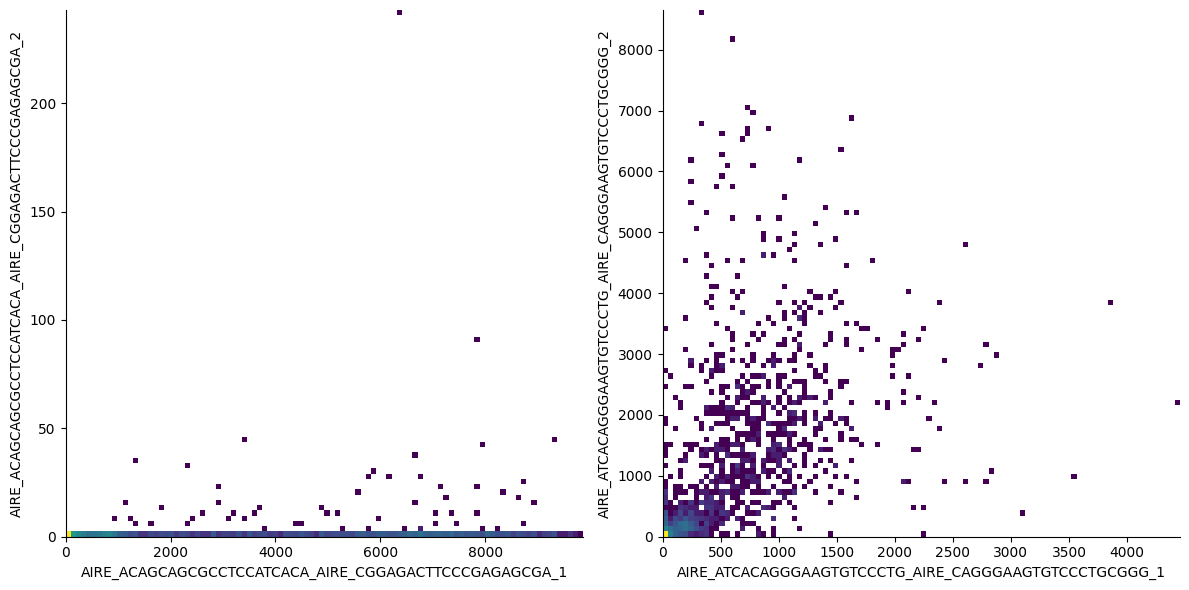

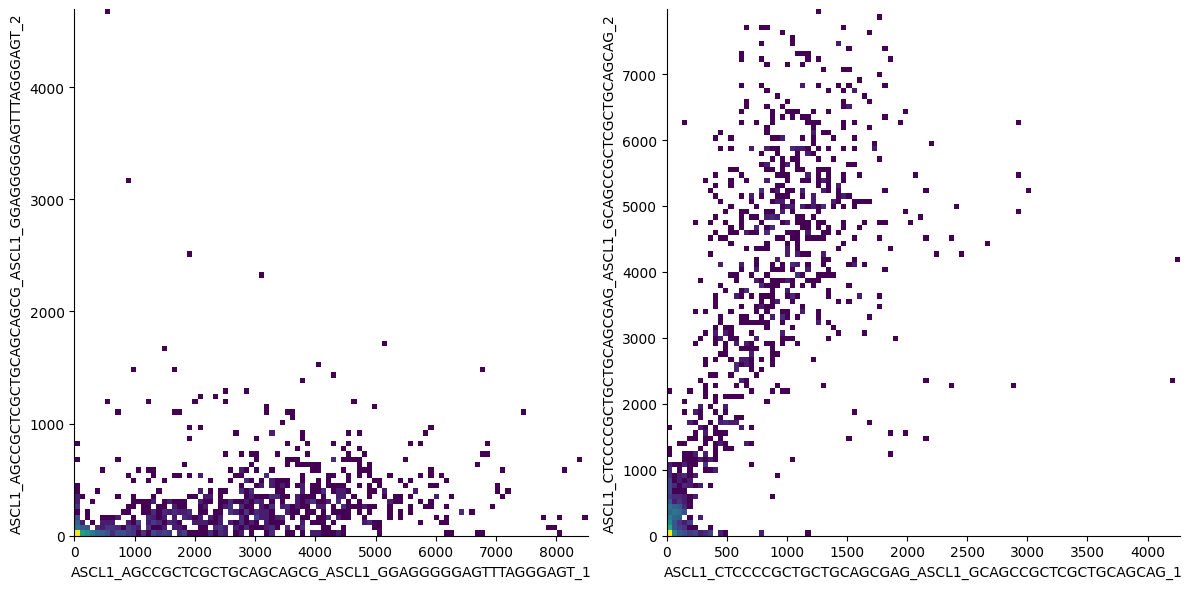

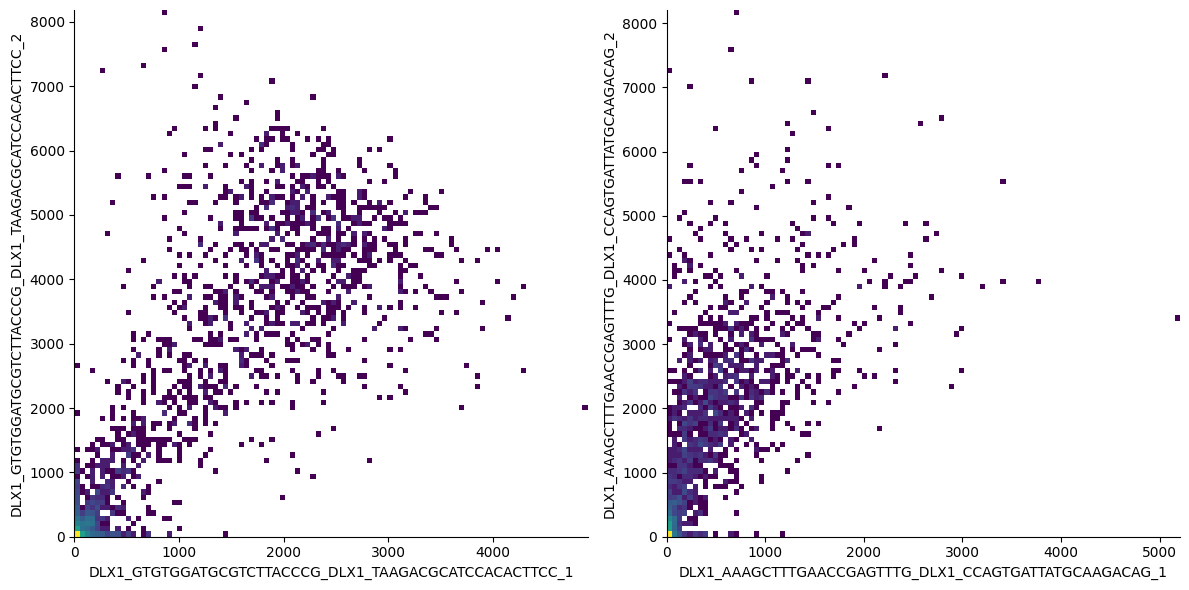

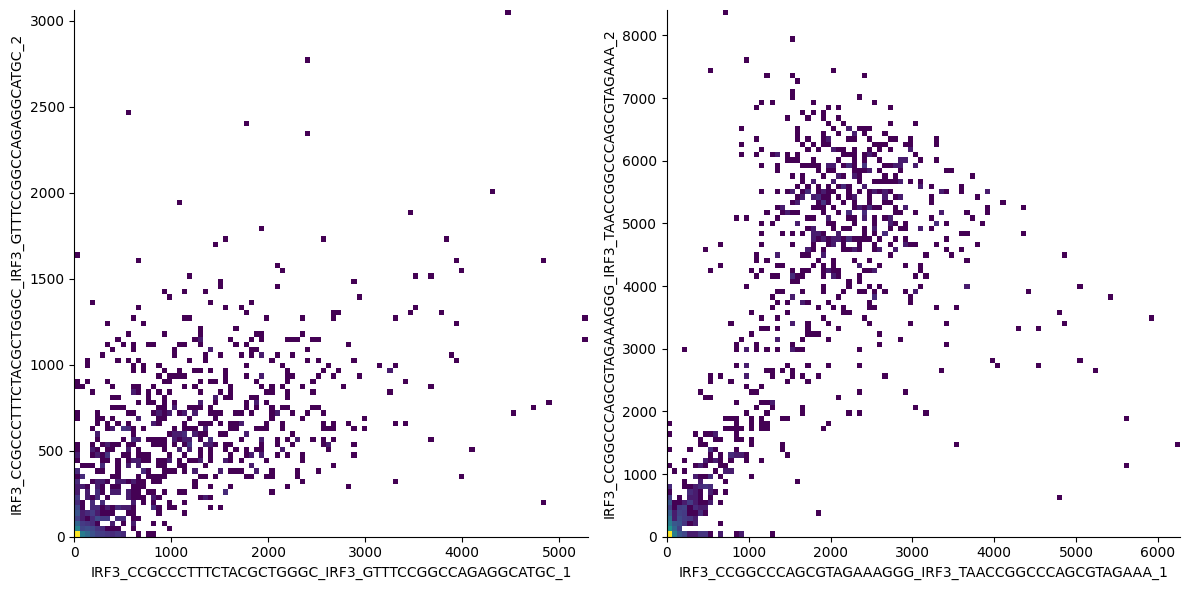

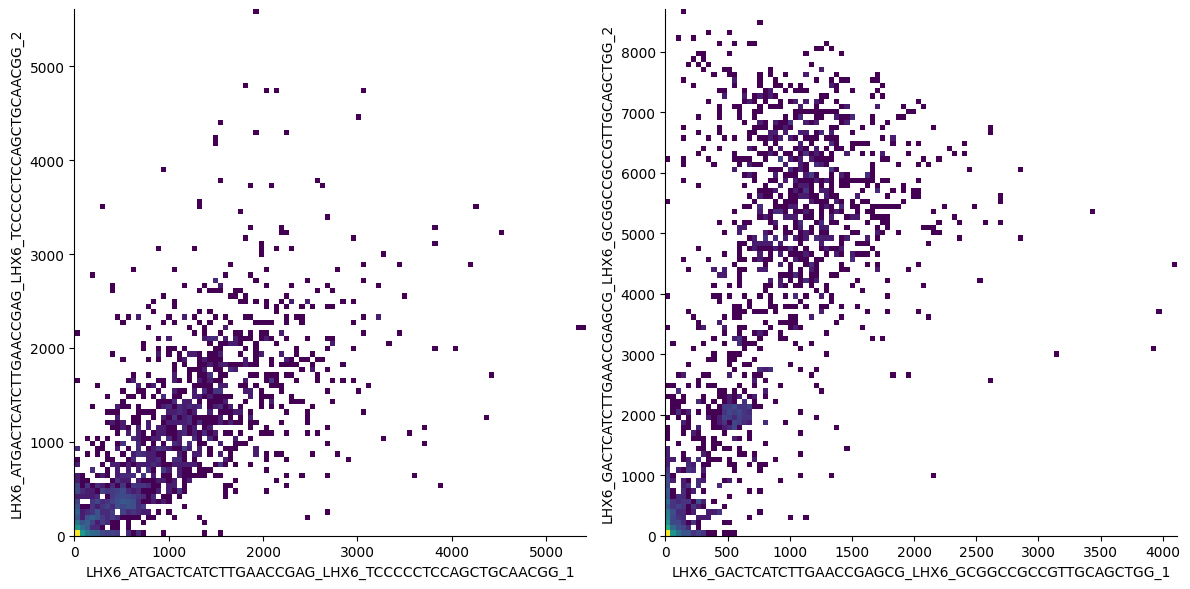

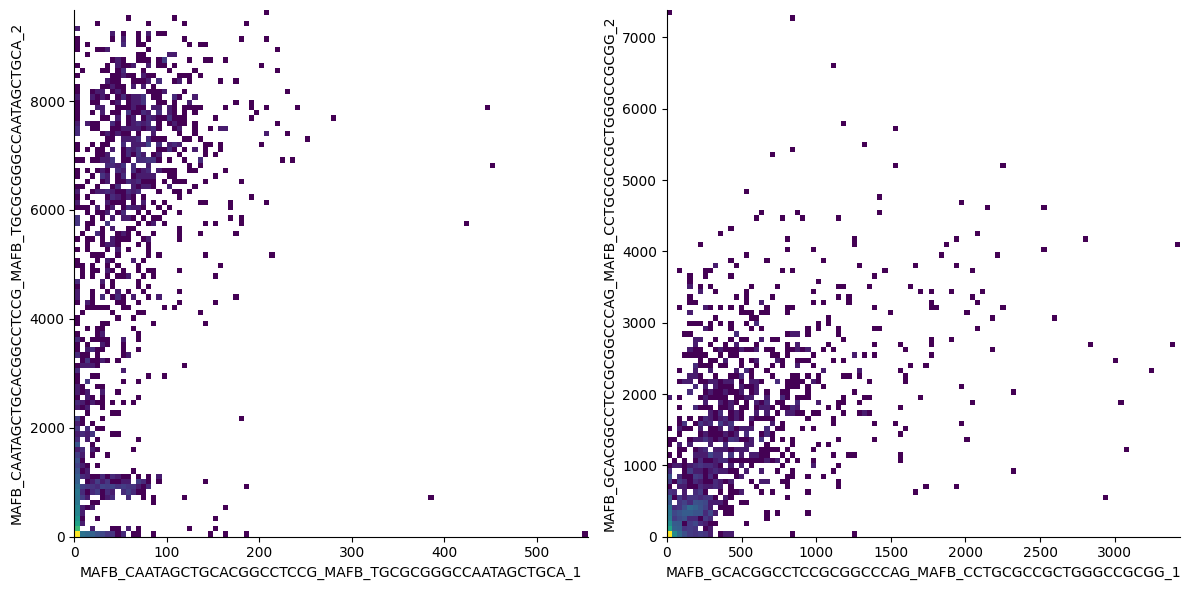

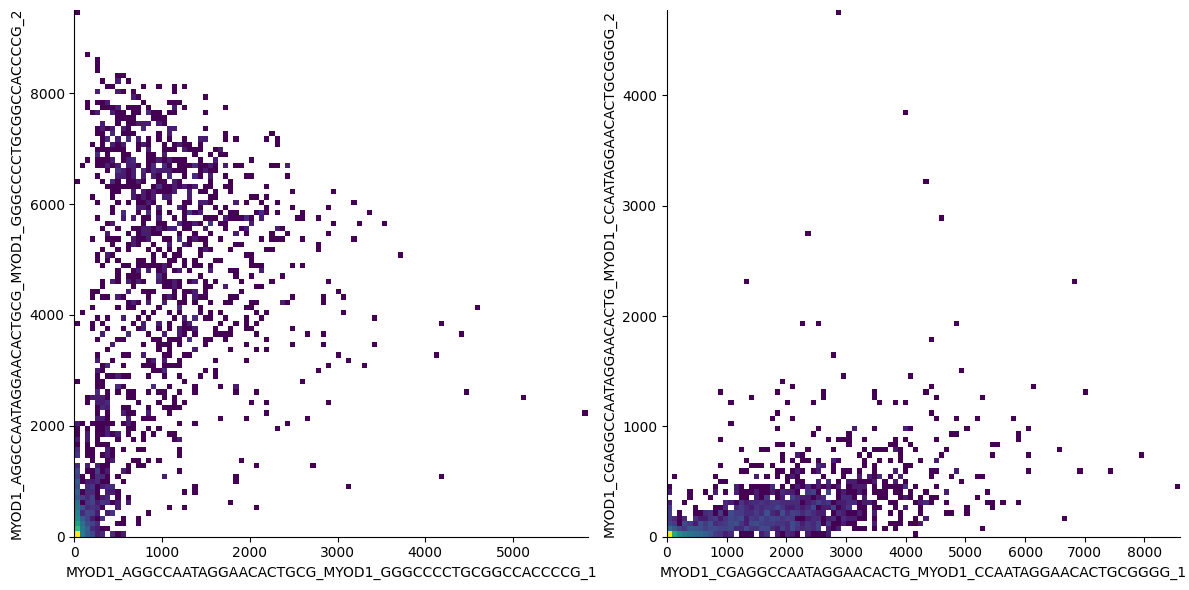

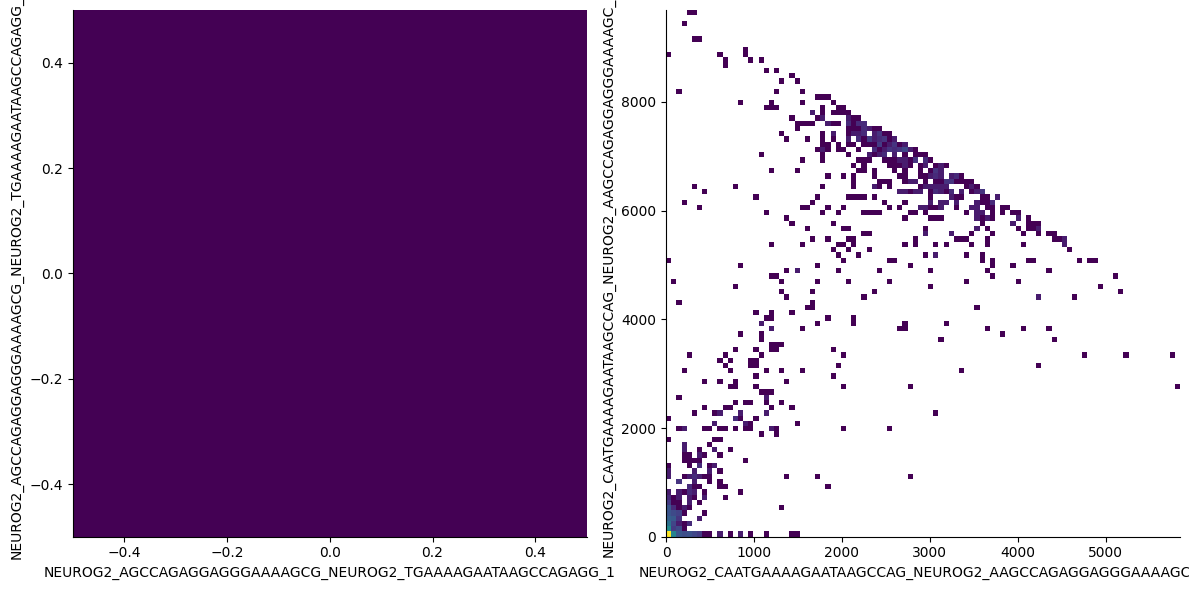

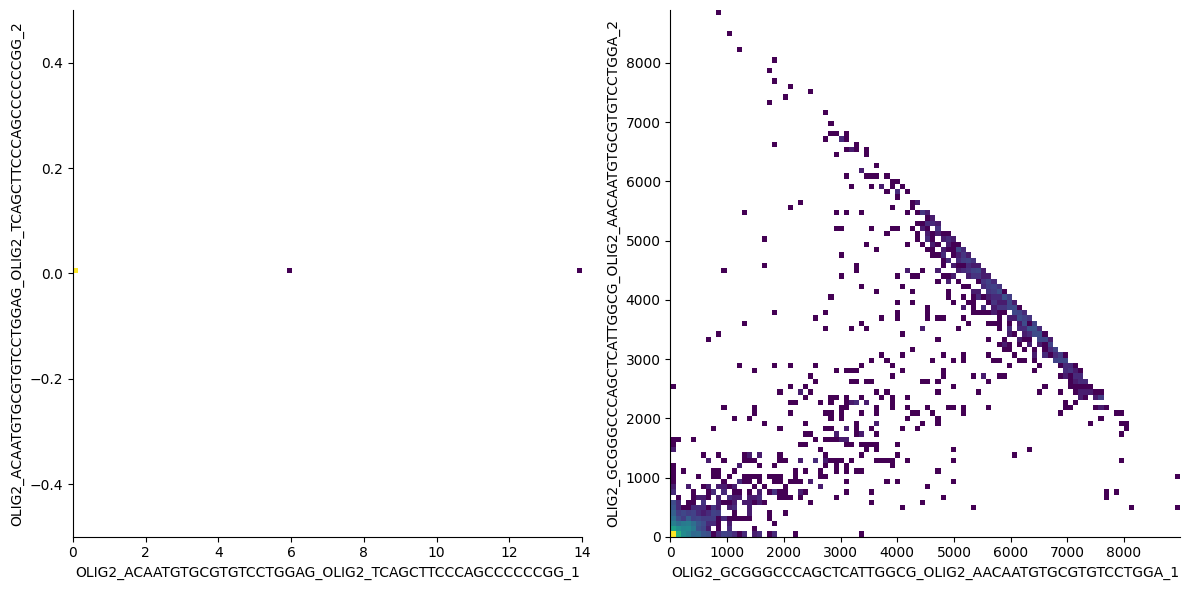

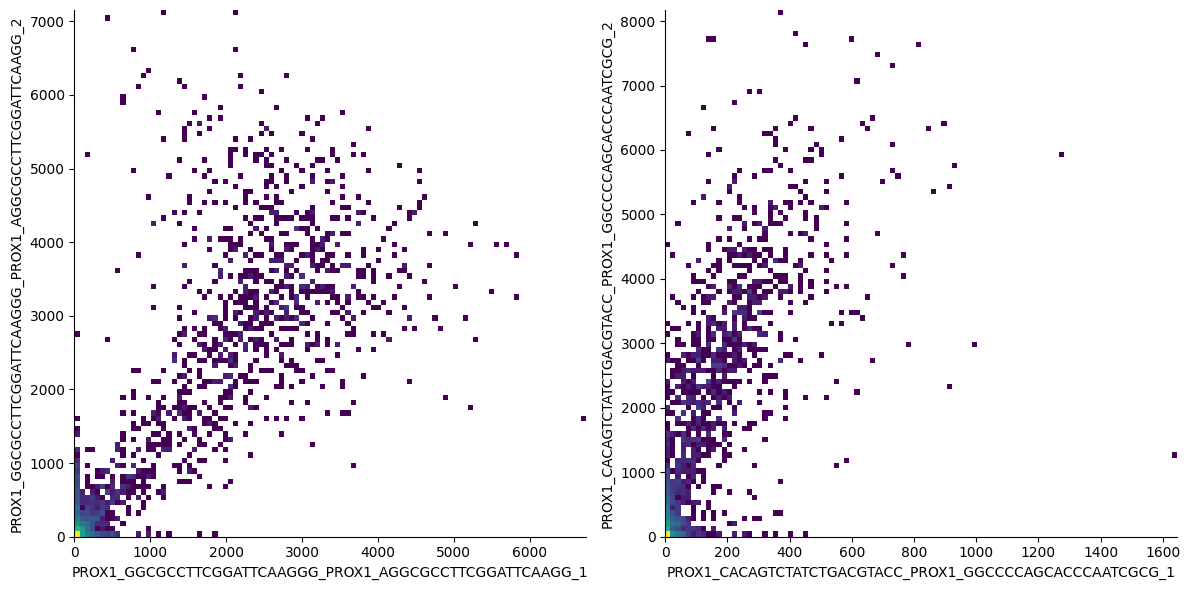

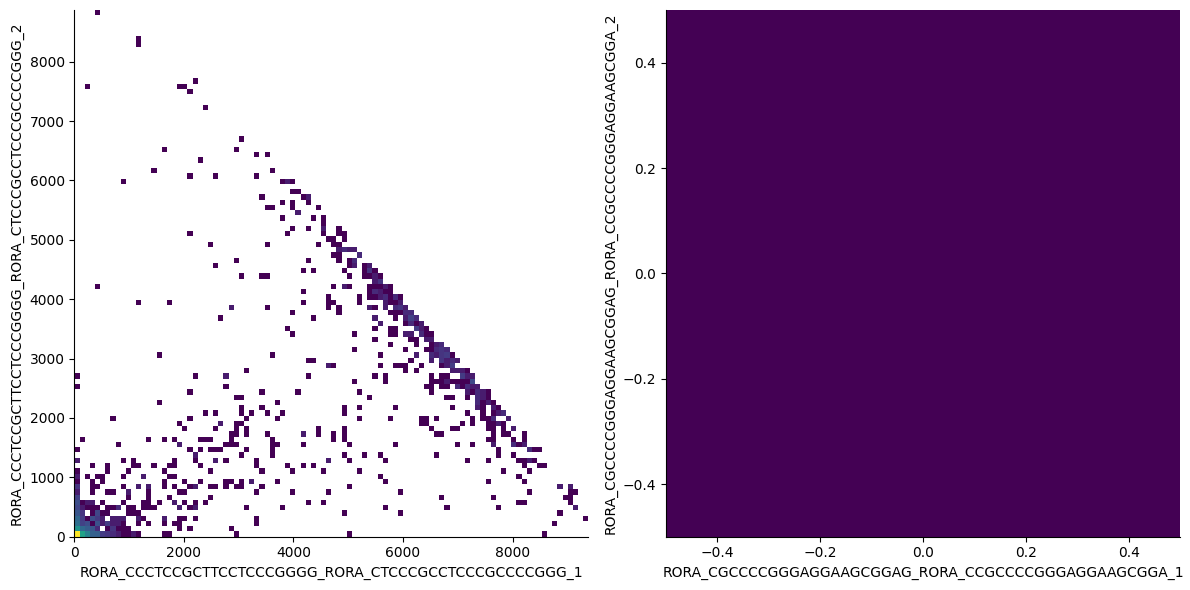

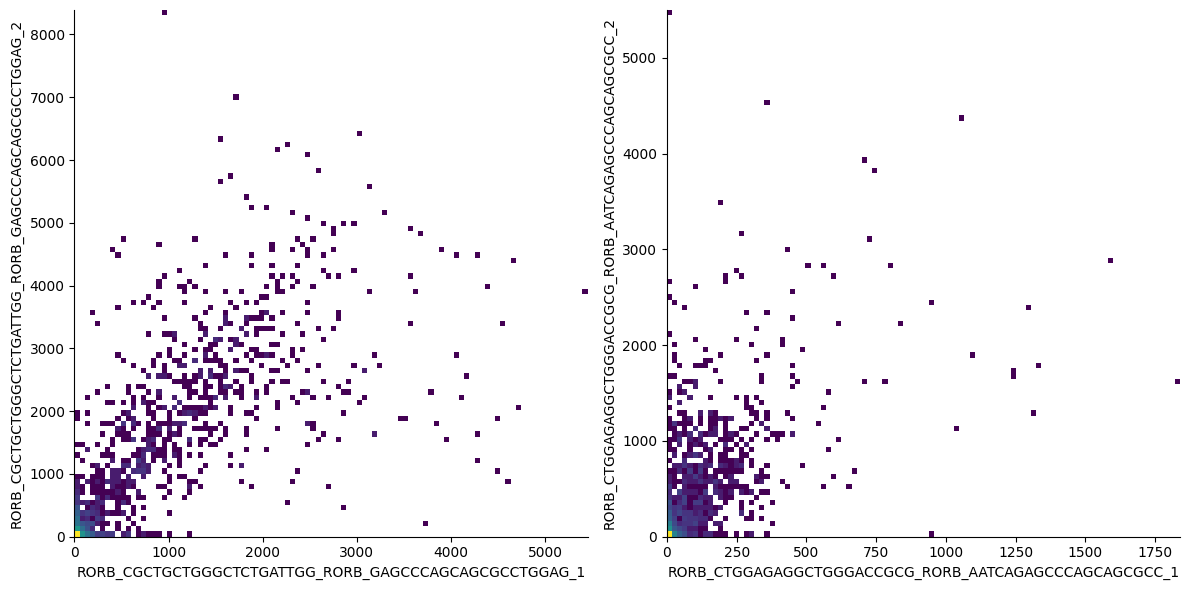

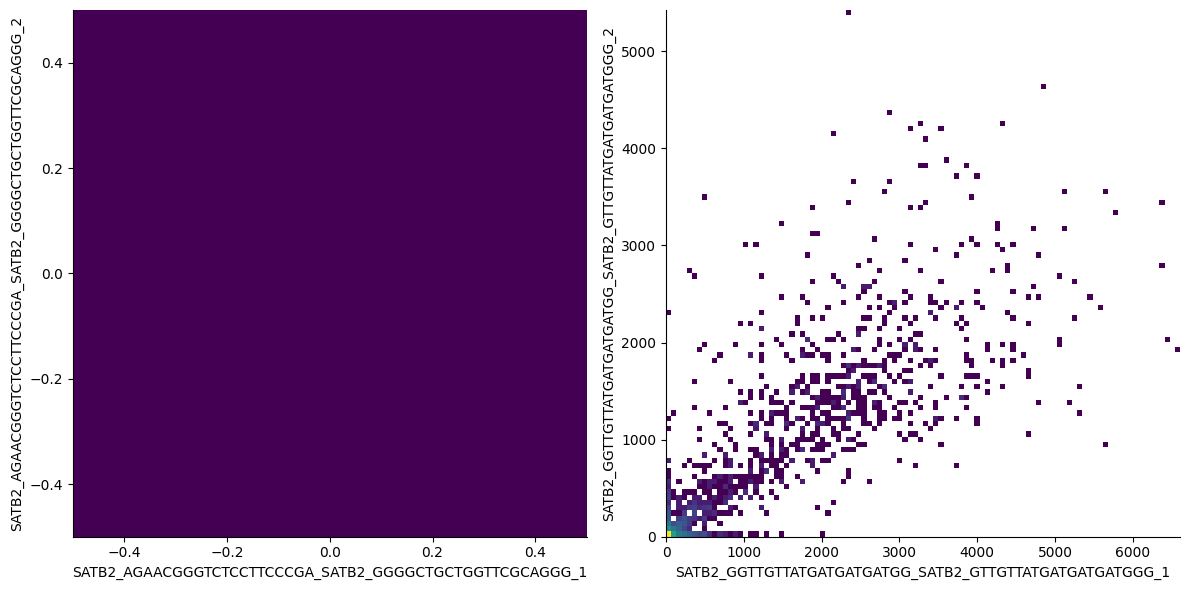

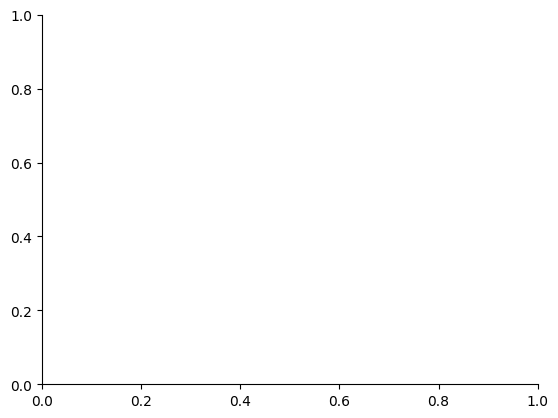

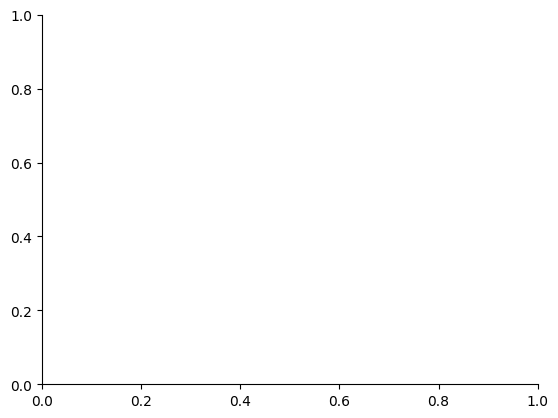

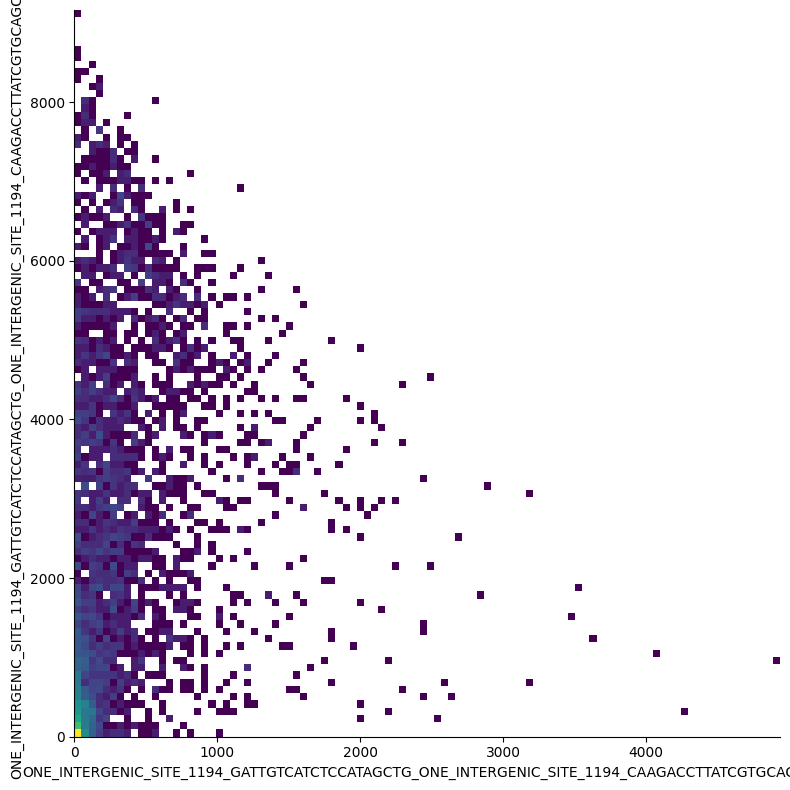

In [74]:
#extract unique guide names from adata.var_names without _1 or _2 extension

#use raw counts for plotting
guides = adata_filtered.var_names.str.rstrip('_1|_2').unique()
for short_name in expected_guides:
    tmp_guides = guides[guides.str.contains(short_name)]
    fig,axs = plt.subplots(1,len(tmp_guides))

    for i,guide_name in enumerate(tmp_guides):
        print(guide_name)
        
        hist2d = adata_filtered[:,adata_filtered.var_names.str.contains(guide_name)]
        hist2d=sparse_to_2d_arr(hist2d)
        
        if hist2d.shape[1] == 2:
            #needs to be plotted differently for single subplot and multiple subplots
            if len(tmp_guides) == 2:
                #multiple subplots
                axs[i].hist2d(hist2d[:,0],hist2d[:,1],bins=100,density=True, 
                    norm = colors.LogNorm())
                #add x and y label
                axs[i].set_xlabel(f'{guide_name}_1')
                axs[i].set_ylabel(f'{guide_name}_2')
                fig.set_figheight(6)
                fig.set_figwidth(12)



            else:
                #single subplot
                axs.hist2d(hist2d[:,0],hist2d[:,1],bins=100,density=True, 
                    norm = colors.LogNorm())
                plt.xlabel(f'{guide_name}_1')
                plt.ylabel(f'{guide_name}_2')
                fig.set_figheight(8)
                fig.set_figwidth(8)



            #plot tigh bbox
            plt.tight_layout()


<h3> 1.2.2 Guide fraction for guide pool</h3>

In [75]:
#assign pools based on experimental design
adata_filtered.var['guide_pool'] = adata_filtered.var_names.str.split('_').str[0]
#assign control guides to control pool
adata_filtered.var.loc[adata_filtered.var['guide_pool'].isin(['sgRNA1', 'sgRNA6', 'ONE']), 'guide_pool'] = 'non_activating'

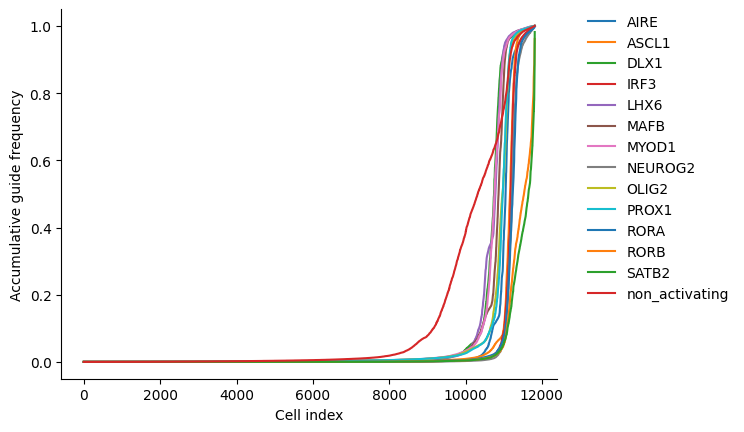

In [95]:
guide_pool_list = []
#calculate fraction of each guide pool
for pool in adata_filtered.var['guide_pool'].unique():

    #calculate fraction of each guide pool    
    idx = np.where(adata_filtered.var['guide_pool'] == pool)[0]
    tmp_frac = dense_count_2d_arr[:,idx].sum(axis=1)/dense_count_2d_arr.sum(axis=1)
    guide_pool_list.append(tmp_frac)
    tmp_frac.sort(axis=0)
    
    plt.plot(tmp_frac)
    #plot legend with short_name
    plt.legend(adata_filtered.var['guide_pool'].unique(),bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel('Cell index')
    
    plt.ylabel('Accumulative guide frequency')
plt.savefig(f'{figures_folder}{today}_guide_pool_fraction_per_cell.pdf',bbox_inches='tight')
    

AIRE
(11814, 2)
1
(11814, 2)
2
ASCL1
(11814, 2)
1
(11814, 2)
2
DLX1
(11814, 2)
1
(11814, 2)
2
IRF3
(11814, 2)
1
(11814, 2)
2
LHX6
(11814, 2)
1
(11814, 2)
2
MAFB
(11814, 2)
1
(11814, 2)
2
MYOD1
(11814, 2)
1
(11814, 2)
2
NEUROG2
(11814, 2)
1
(11814, 2)
2
OLIG2
(11814, 2)
1
(11814, 2)
2
PROX1
(11814, 2)
1
(11814, 2)
2
RORA
(11814, 2)
1
(11814, 2)
2
RORB
(11814, 2)
1
(11814, 2)
2
SATB2
(11814, 2)
1
(11814, 2)
2
sgRNA1_SCP
sgRNA6_SCP
ONE_INTERGENIC_SITE_1194


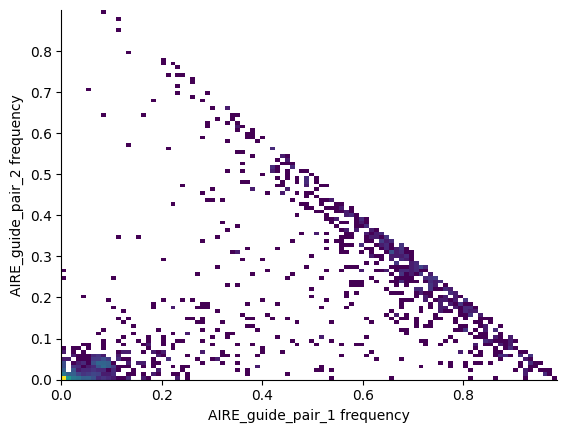

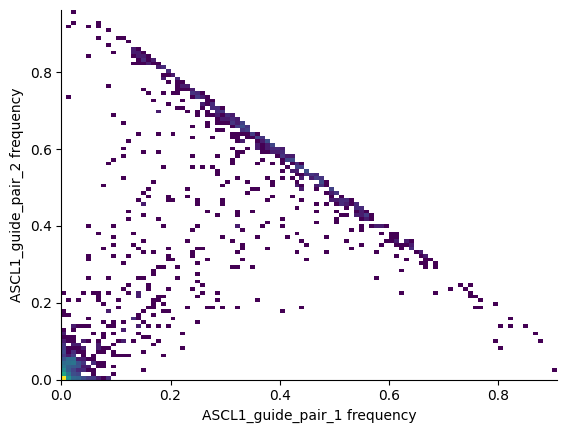

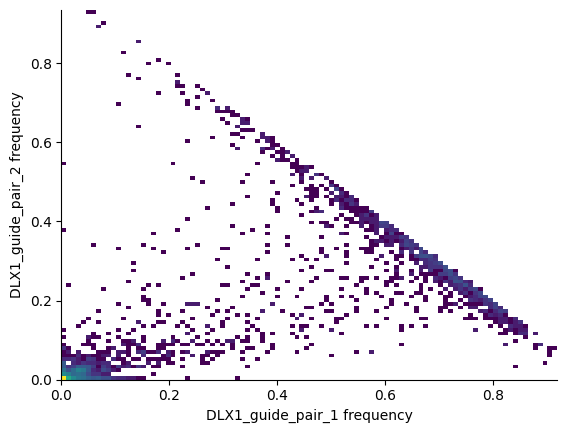

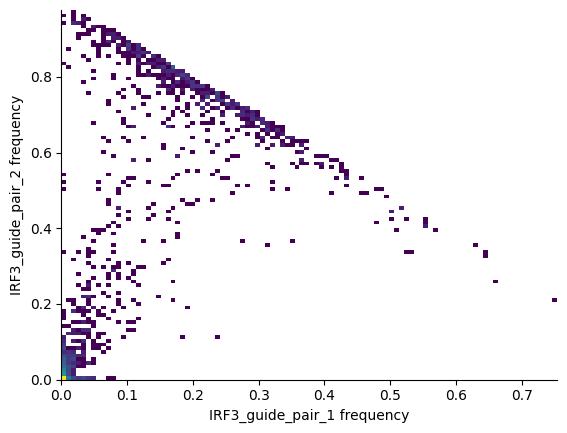

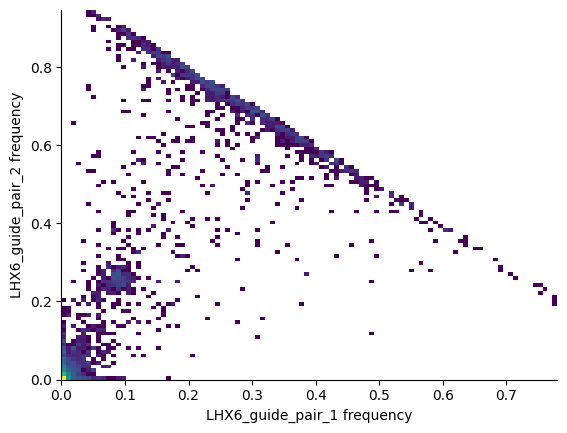

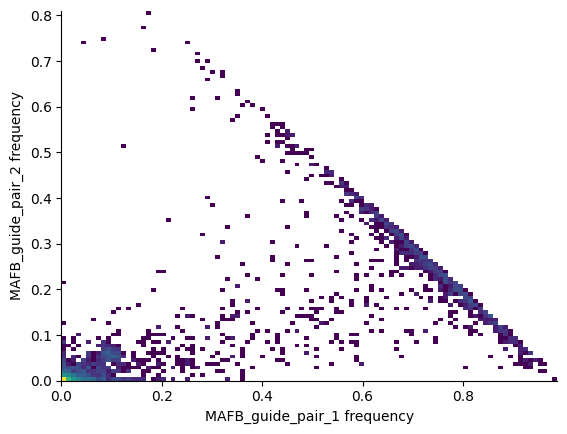

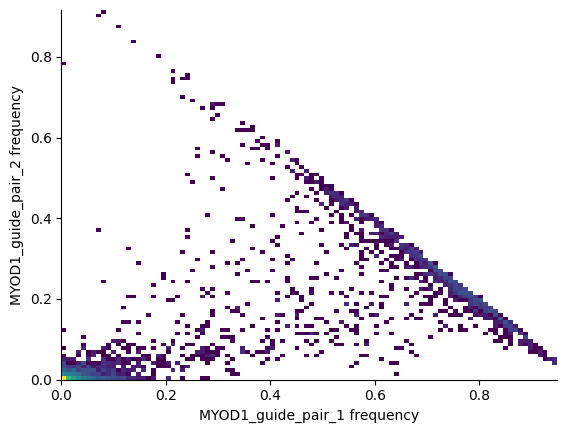

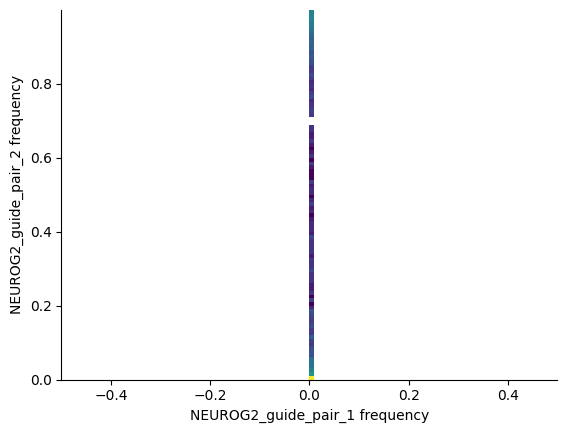

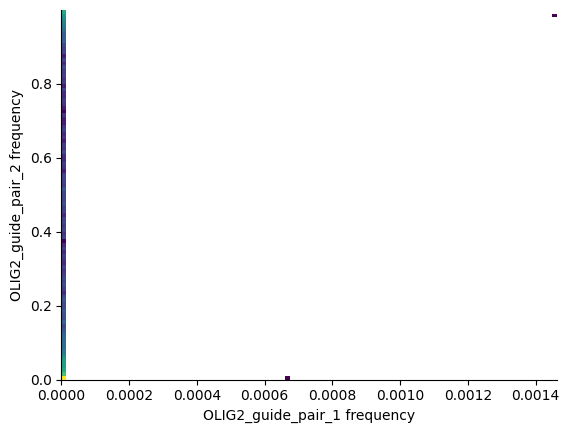

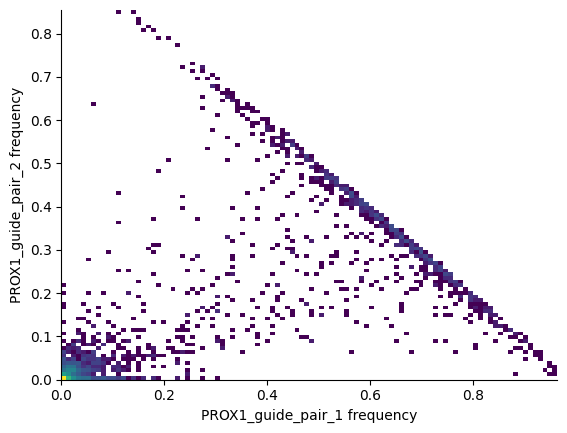

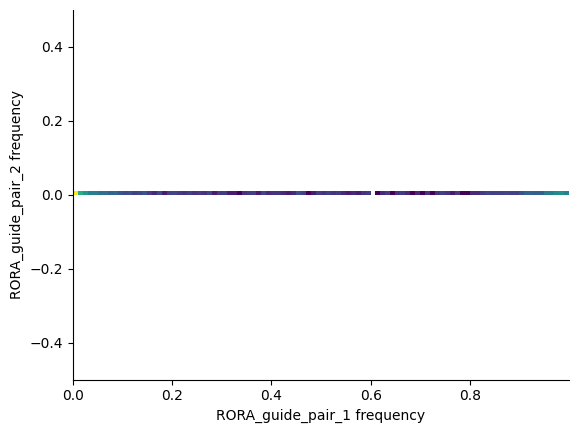

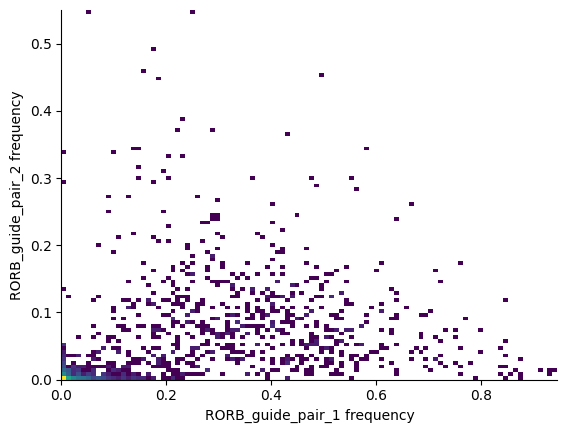

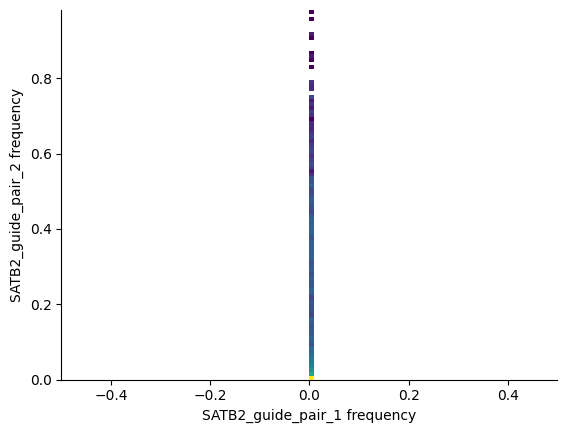

In [82]:
#create folder for figures if it does not exist 
hist_2d_freq_folder = os.path.join(figures_folder, 'hist2d_frequency/')

if not os.path.exists(hist_2d_freq_folder):
    os.makedirs(hist_2d_freq_folder)

guides = adata_filtered.var_names.str.rstrip('_1|_2').unique()
for short_name in expected_guides:
    tmp_guides = guides[guides.str.contains(short_name)]



    
    if len(tmp_guides) == 2:
        #create empty list to store fraction of each guide pair
        curr_guide_pool = []
        fig,axs = plt.subplots()
            
        for i,guide_name in enumerate(tmp_guides):
            tmp_adata=adata_filtered[:,adata_filtered.var_names.str.contains(guide_name)]
            #calculate fraction of each guide pair
            tmp_frac = tmp_adata.X.sum(axis=1)/adata_filtered.X.sum(axis=1)
            curr_guide_pool.append(tmp_frac)
            print(len(curr_guide_pool))
            
        #concatenate all fractions of each guide pair
        curr_guide_pool = np.concatenate(curr_guide_pool,axis=1)
        #convert to numpy array
        curr_guide_pool = np.array(curr_guide_pool)
        
        
        #plot scatter plot of guide pair fraction
        
        plt.hist2d(curr_guide_pool[:,0],curr_guide_pool[:,1],bins=100,density=True, 
                        norm = colors.LogNorm())
        #add x and y label
        plt.xlabel(f'{short_name}_guide_pair_1 frequency')
        plt.ylabel(f'{short_name}_guide_pair_2 frequency')

        #save figure
        plt.savefig(f'{hist_2d_freq_folder}{today}_{short_name}_guide_pair_frequency.pdf',bbox_inches='tight')

(11814, 4)
1
(11814, 4)
2


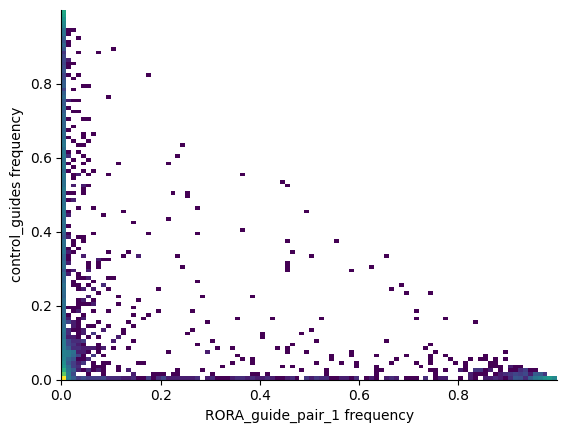

In [85]:
#create empty list to store fraction of each guide pair
curr_guide_pool = []
fig,axs = plt.subplots()
    
for i,guide_name in enumerate(['RORA','non_activating']):
    tmp_adata=adata_filtered[:,np.where(adata_filtered.var['guide_pool'] == guide_name)[0]]
    print(tmp_adata.X.shape)
    #calculate fraction of each guide pair
    tmp_frac = tmp_adata.X.sum(axis=1)/adata_filtered.X.sum(axis=1)
    curr_guide_pool.append(tmp_frac)
    print(len(curr_guide_pool))
    
#concatenate all fractions of each guide pair
curr_guide_pool = np.concatenate(curr_guide_pool,axis=1)
#convert to numpy array
curr_guide_pool = np.array(curr_guide_pool)


#plot scatter plot of guide pair fraction

plt.hist2d(curr_guide_pool[:,0],curr_guide_pool[:,1],bins=100,density=True, 
                norm = colors.LogNorm())
#add x and y label
plt.xlabel(f'RORA_guide_pair_1 frequency')
plt.ylabel(f'control_guides frequency')
#save figure
plt.savefig(f'{hist_2d_freq_folder}{today}_RORA_guide_pair_frequency.pdf',bbox_inches='tight')

(11814, 4)
1
(11814, 4)
2


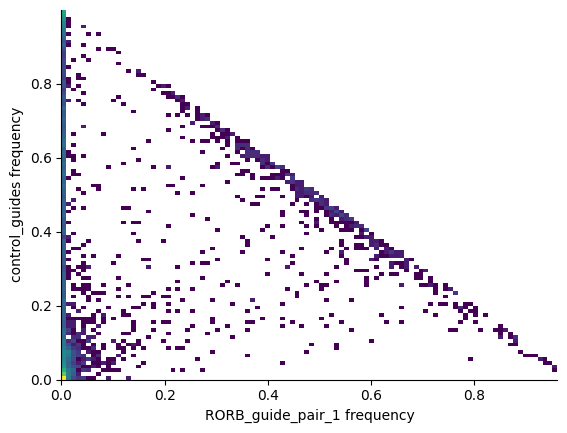

In [87]:
#create empty list to store fraction of each guide pair
curr_guide_pool = []
fig,axs = plt.subplots()
    
for i,guide_name in enumerate(['RORB','non_activating']):
    tmp_adata=adata_filtered[:,np.where(adata_filtered.var['guide_pool'] == guide_name)[0]]
    print(tmp_adata.X.shape)
    #calculate fraction of each guide pair
    tmp_frac = tmp_adata.X.sum(axis=1)/adata_filtered.X.sum(axis=1)
    curr_guide_pool.append(tmp_frac)
    print(len(curr_guide_pool))
    
#concatenate all fractions of each guide pair
curr_guide_pool = np.concatenate(curr_guide_pool,axis=1)
#convert to numpy array
curr_guide_pool = np.array(curr_guide_pool)


#plot scatter plot of guide pair fraction

plt.hist2d(curr_guide_pool[:,0],curr_guide_pool[:,1],bins=100,density=True, 
                norm = colors.LogNorm())
#add x and y label
plt.xlabel(f'RORB_guide_pair_1 frequency')
plt.ylabel(f'control_guides frequency')

plt.savefig(f'{hist_2d_freq_folder}{today}_RORB_guide_pair_frequency.pdf',bbox_inches='tight')

In [88]:
#create new column called perturbation_state in adata.obs to assign cells to perturbed or control initiliaze with nan
adata_filtered.obs['perturbation_state'] = 'not_perturbed'

In [89]:
guide_pool_fraction = []
for short_name in adata_filtered.var['guide_pool'].unique():

    #filter for guide pool
    tmp_adata=adata_filtered[:,np.where(adata_filtered.var['guide_pool'] == short_name)[0]]




    #calculate fraction of each guide pair
    tmp_frac = tmp_adata.X.sum(axis=1)/adata_filtered.X.sum(axis=1)
    guide_pool_fraction.append(tmp_frac)


    #exception for control guide pool + RORA/RORB guide pool as they were provided as a combined guide pool
    if not(short_name == 'RORA' or short_name == 'RORB'or short_name == 'control'):
        #get index of tmp_frac where fraction is greater than 0.8
        idx = np.where(tmp_frac > 0.8)[0]
        #assign cells to perturbed in perturbation state column in obs
        adata_filtered.obs['perturbation_state'].iloc[idx] = short_name
#concatenate all fractions of each guide pair
guide_pool_fraction = np.concatenate(guide_pool_fraction,axis=1)

/tmp/ipykernel_3230/3119816208.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_filtered.obs['perturbation_state'].iloc[idx] = short_name


In [90]:
#get index for RORA guide pool
RORA_idx = np.where(adata_filtered.var['guide_pool'].unique()== 'RORA')[0][0]
RORB_idx = np.where(adata_filtered.var['guide_pool'].unique()== 'RORB')[0][0]
#get index for non activating guide pool
non_activating_idx = np.where(adata_filtered.var['guide_pool'].unique()== 'non_activating')[0][0]

In [91]:
#set filter for RORA guide pool > 0.8
RORA_filter = np.where(guide_pool_fraction[:,RORA_idx] > 0.8)[0]
#assign cells to perturbed in perturbation state column in obs
adata_filtered.obs['perturbation_state'].iloc[RORA_filter] = 'RORA'
#sum RORB guide pool + control guide fraction as they were provided as a combined guide pool
RORB_filter = np.where(
    (guide_pool_fraction[:,RORB_idx] + guide_pool_fraction[:,non_activating_idx] > 0.8) & 
    (guide_pool_fraction[:,RORB_idx] > 0.4) #filter should reflect the fraction of the guide pool that is RORB 2/5
    )[0]
adata_filtered.obs['perturbation_state'].iloc[RORB_filter] = 'RORB'
#assign non-targeting without any RORA/RORB guide pool
non_targeting_filter = np.where(
    (guide_pool_fraction[:,non_activating_idx]>0.8) &
    (guide_pool_fraction[:,RORA_idx] == 0) &
    (guide_pool_fraction[:,RORB_idx] == 0)
)[0]
adata_filtered.obs['perturbation_state'].iloc[non_targeting_filter] = 'non_activating'



/tmp/ipykernel_3230/2702730848.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_filtered.obs['perturbation_state'].iloc[RORA_filter] = 'RORA'
/tmp/ipykernel_3230/2702730848.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_filtered.obs['perturbation_state'].iloc[RORB_filter] = 'RORB'
/tmp/ipykernel_3230/2702730848.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_filtered.obs['perturbation_state'].iloc[non_ta

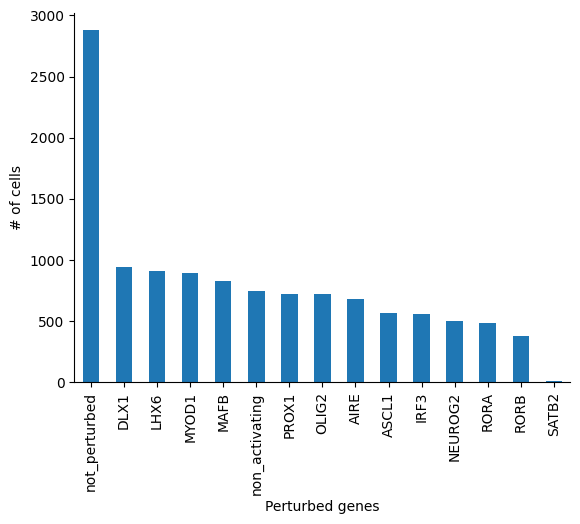

In [96]:
adata_filtered.obs['perturbation_state'].value_counts()
#create a bar chart from the value counts of perturbation state
adata_filtered.obs['perturbation_state'].value_counts().plot.bar()
#add x and y label to bar chart
plt.xlabel('Perturbed genes')
plt.ylabel('# of cells')
#save figure in figures folder with today's date
plt.savefig(f'{figures_folder}/{today}_perturbation_state_barplot.pdf',dpi=300, bbox_inches='tight')


In [97]:
#save adat_filter obs as csv file
adata_filtered.obs.to_csv(f'/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/data/crispra_data_exploration/{today}_perturbation_state.csv')
